##  **Transfer Learning**

### 1. 1. Loading Packages


In [ ]:
# Import the required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import tensorflow
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')


### 1. 2. Load and Explore Data

In [ ]:
# !wget -O data.zip https://www.dropbox.com/scl/fi/x9wbnxox44rey6xym4un7/data.zip?rlkey=uo2pos87olc6zgkdhp5dcverb&raw=1
# !unzip data.zip

we will notice that we have three subfolders inside `chest_xray`: train, test, and validation. These will be used for building and evaluating our model's performance. Within each of these folders, we have two subfolders: **NORMAL** and **PNEUMONIA**.

In [ ]:
import os
main_dir = 'chest_xray'
train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')
val_dir = os.path.join(main_dir, 'val')


#### 1. 2. 1. The path's variables below point to the negative and positive instances of the training and testing sets (folders). We will use these to check the class distribution in our dataset. In other words, how many positive and negative instances are available. Recall, a hugely imbalanced dataset can lead to biased results.


In [ ]:
normal_train_dir = os.path.join(train_dir, 'NORMAL')
pneumonia_train_dir = os.path.join(train_dir, 'PNEUMONIA')
normal_test_dir = os.path.join(test_dir, 'NORMAL')
pneumonia_test_dir = os.path.join(test_dir, 'PNEUMONIA')
normal_val_dir = os.path.join(val_dir, 'NORMAL')
pneumonia_val_dir = os.path.join(val_dir, 'PNEUMONIA')

print("Training Normal Directory:", normal_train_dir)
print("Training Pneumonia Directory:", pneumonia_train_dir)
print("Testing Normal Directory:", normal_test_dir)
print("Testing Pneumonia Directory:", pneumonia_test_dir)
print("Validation Pneumonia Directory:", normal_val_dir)
print("Validation Pneumonia Directory:", pneumonia_val_dir)

Training Normal Directory: chest_xray\train\NORMAL
Training Pneumonia Directory: chest_xray\train\PNEUMONIA
Testing Normal Directory: chest_xray\test\NORMAL
Testing Pneumonia Directory: chest_xray\test\PNEUMONIA
Validation Pneumonia Directory: chest_xray\val\NORMAL
Validation Pneumonia Directory: chest_xray\val\PNEUMONIA


#### 1. 2. 2. Now create a function to load data to Python.



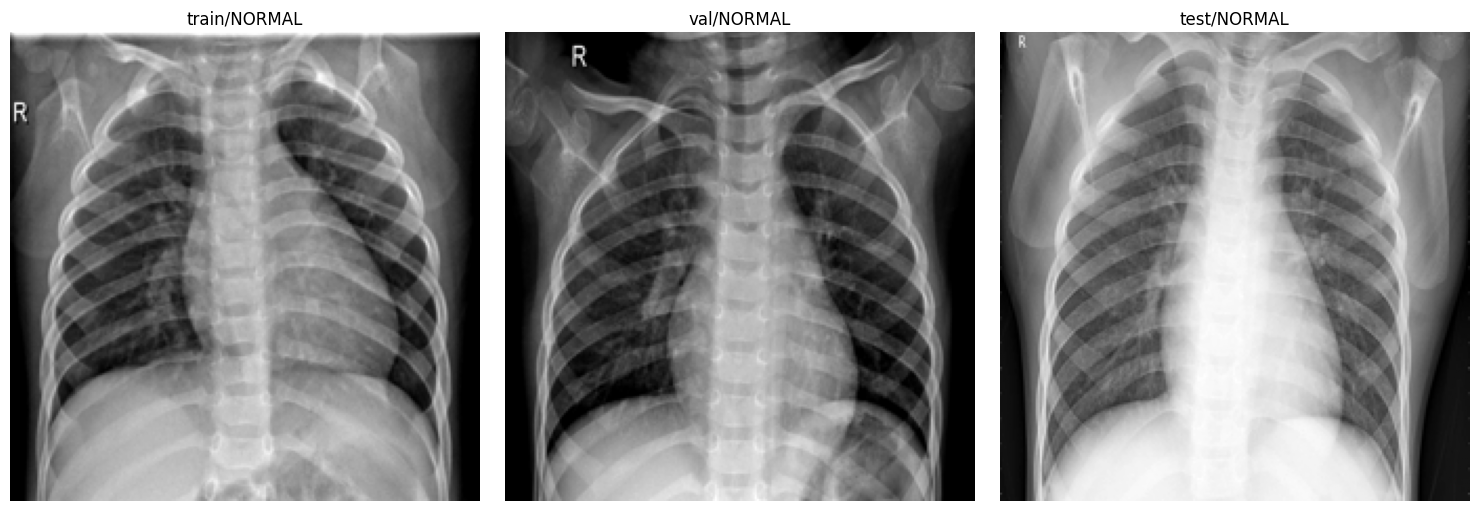

In [ ]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import numpy as np

def load_images(base_directory, dataset_type, subfolder="NORMAL"):
    """
    Load all image file paths from a specified subfolder of a dataset type.

    Args:
        base_directory (str): Path to the base directory containing dataset subfolders.
        dataset_type (str): The dataset type ('train', 'val', or 'test').
        subfolder (str): Subfolder name (e.g., 'NORMAL', default: 'NORMAL').

    Returns:
        list: List of file paths to images in the specified subfolder.
    """
    directory = os.path.join(base_directory, dataset_type, subfolder)
    if not os.path.exists(directory):
        print(f"Error: Directory '{directory}' does not exist.")
        return []

    # Get all image file paths
    return [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

def select_random_image(image_paths):
    """
    Select a random image file path from a list of image paths.

    Args:
        image_paths (list): List of image file paths.

    Returns:
        str or None: Path to the selected image, or None if the list is empty.
    """
    if not image_paths:
        print("No image paths available to select from.")
        return None
    return random.choice(image_paths)

def process_image(image_path, image_size=(224, 224)):
    """
    Load and resize an image from the given file path.

    Args:
        image_path (str): Path to the image file.
        image_size (tuple): Target size of the image (width, height).

    Returns:
        numpy array or None: Processed image as a numpy array, or None if loading fails.
    """
    try:
        with Image.open(image_path) as img:
            return np.array(img.resize(image_size))
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def display_images(images_with_titles):
    """
    Display images in a horizontal subplot.

    Args:
        images_with_titles (list): List of tuples (image, title), where:
            - image (numpy array or None): Image data to display (None if unavailable).
            - title (str): Title for the image.
    """
    fig, axes = plt.subplots(1, len(images_with_titles), figsize=(15, 5))
    for ax, (img, title) in zip(axes, images_with_titles):
        if img is not None:
            ax.imshow(img,cmap='grey')
            ax.axis('off')
            ax.set_title(title)
        else:
            ax.axis('off')
            ax.set_title(title)
    plt.tight_layout()
    plt.show()

images_with_titles = []

for dataset_type in ["train", "val", "test"]:
    # Step 1: Load all image paths
    image_paths = load_images(main_dir, dataset_type, subfolder='NORMAL')

    # Step 2: Select a random image
    random_image_path = select_random_image(image_paths)

    if random_image_path:
        # Step 3: Process the selected image
        processed_image = process_image(random_image_path, image_size=(224, 224))
        images_with_titles.append((processed_image, f"{dataset_type}/{'NORMAL'}"))
    else:
        images_with_titles.append((None, f"{dataset_type}/{'NORMAL'} (No Image)"))

display_images(images_with_titles)


 #### 1. 2. 3. show the class distributions (0 denotes a normal image, while 1 denotes an image depicting pneumonia) in train and test.
 

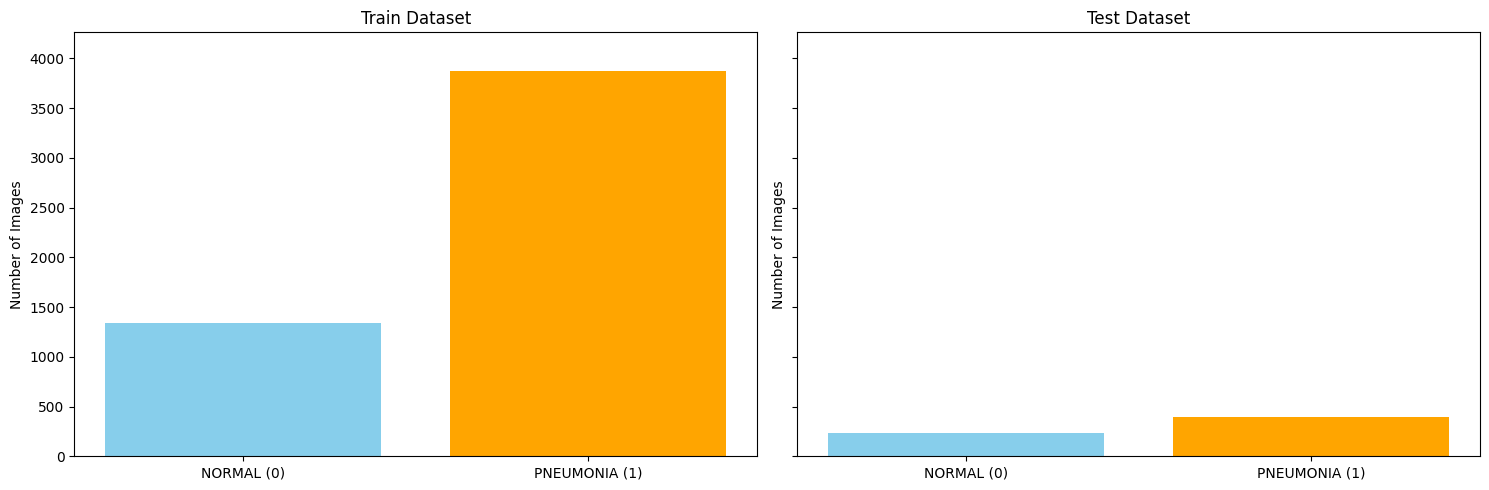

In [ ]:
def count_class_distributions_with_loader(main_dir, dataset_type):
    """
    Count the class distributions (NORMAL: 0, PNEUMONIA: 1).

    Args:
        main_dir (str): Path to the base directory containing dataset subfolders.
        dataset_type (str): The dataset type ('train' or 'test').

    Returns:
        dict: Dictionary with class labels (0: NORMAL, 1: PNEUMONIA) as keys and counts as values.
    """
    class_labels = {"NORMAL": 0, "PNEUMONIA": 1}
    distribution = {0: 0, 1: 0}

    for subfolder, label in class_labels.items():
        # Use load_images to get image paths
        image_paths = load_images(main_dir, dataset_type, subfolder=subfolder)
        distribution[label] = len(image_paths)

    return distribution

def plot_class_distributions(distributions, dataset_types):
    """
    Plot the class distributions for each dataset type.

    Args:
        distributions (dict): Dictionary where keys are dataset types, and values are class distributions.
        dataset_types (list): List of dataset types (e.g., ['train', 'test']).
    """
    fig, axes = plt.subplots(1, len(dataset_types), figsize=(15, 5), sharey=True)
    for ax, dataset_type in zip(axes, dataset_types):
        data = distributions[dataset_type]
        ax.bar(["NORMAL (0)", "PNEUMONIA (1)"], [data[0], data[1]], color=['skyblue', 'orange'])
        ax.set_title(f"{dataset_type.capitalize()} Dataset")
        ax.set_ylabel("Number of Images")
        ax.set_ylim(0, max(max(data.values()) for data in distributions.values()) * 1.1)

    plt.tight_layout()
    plt.show()

dataset_types = ["train", "test"]

# Count and plot class distributions
distributions = {dataset_type: count_class_distributions_with_loader(main_dir, dataset_type) for dataset_type in dataset_types}
plot_class_distributions(distributions, dataset_types)


#### 1. 2. 4. Write a function to show arbitray number of normal or pneumonia images.


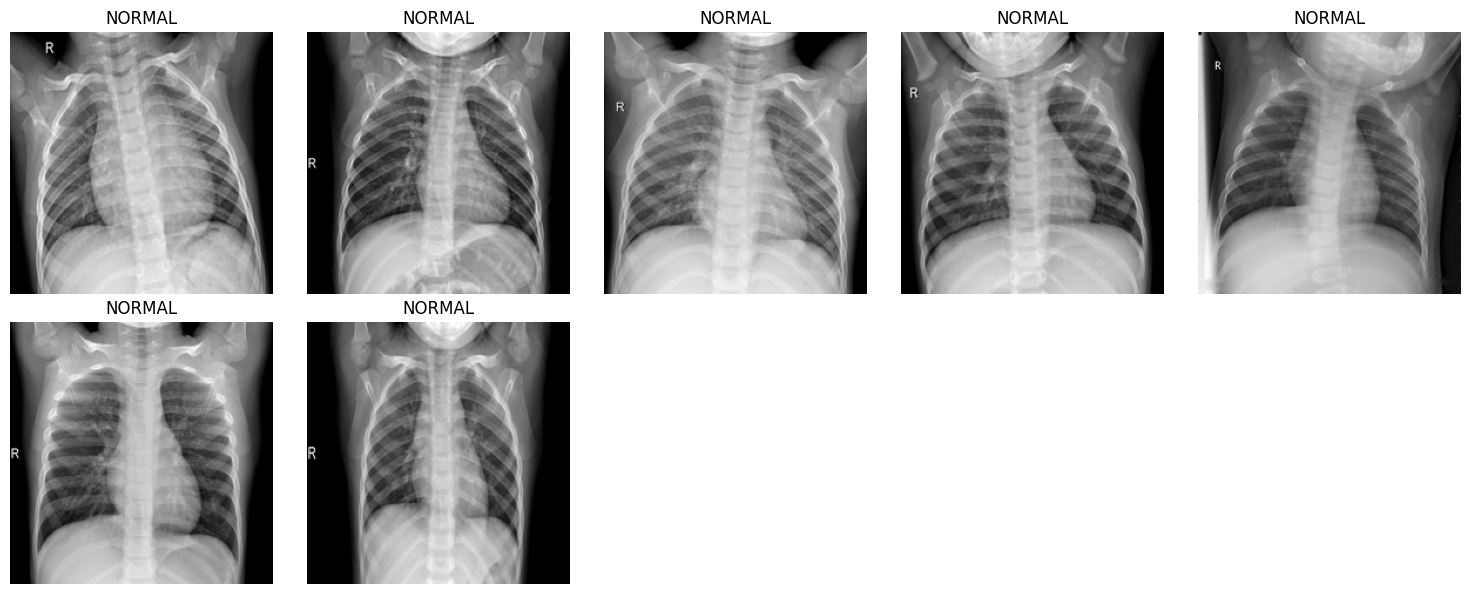

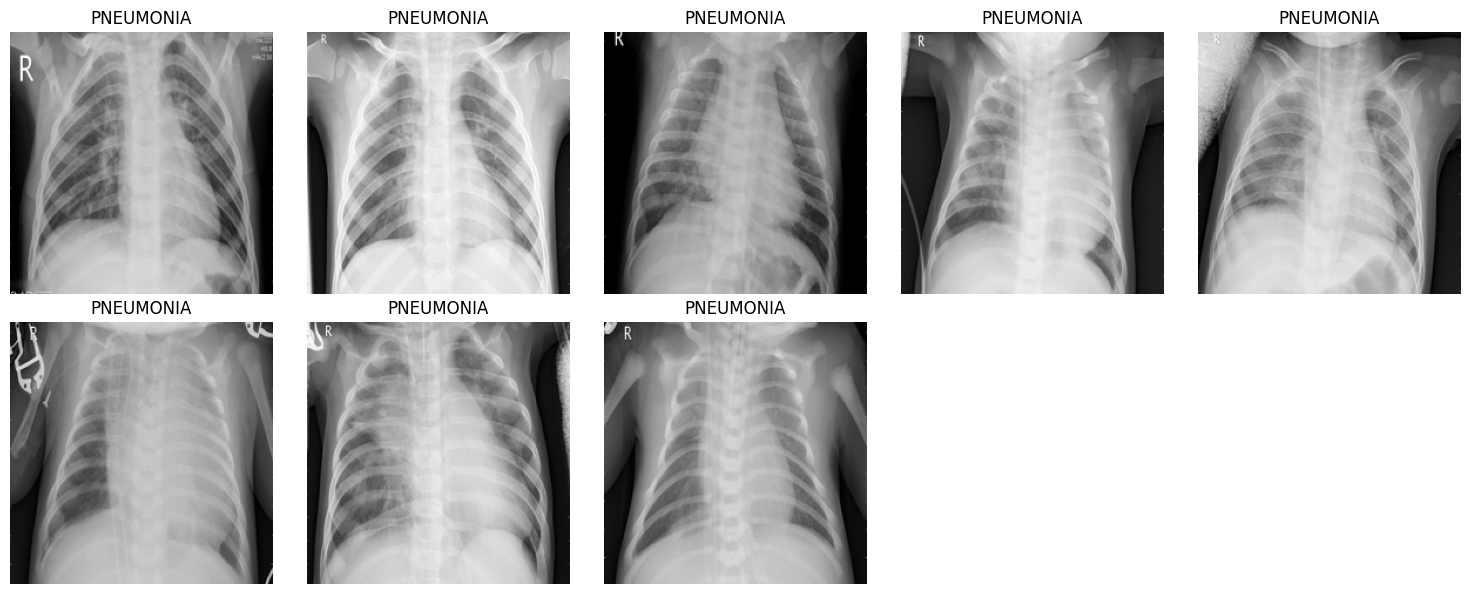

In [ ]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def show_images(main_dir, dataset_type, class_type, num_images, image_size=(224, 224)):
    """
    Display an arbitrary number of images from the specified class type ('NORMAL' or 'PNEUMONIA').

    Args:
        main_dir (str): Path to the base directory containing dataset subfolders.
        dataset_type (str): The dataset type ('train', 'val', or 'test').
        class_type (str): Class type to display ('NORMAL' or 'PNEUMONIA').
        num_images (int): Number of images to display.
        image_size (tuple): Tuple specifying the target size of the images (width, height).
    """
    # Step 1: Load image paths
    image_paths = load_images(main_dir, dataset_type, subfolder=class_type)

    if not image_paths:
        print(f"No images found in {dataset_type}/{class_type}.")
        return

    # Step 2: Randomly select the required number of images
    num_images = min(num_images, len(image_paths))  # Avoid selecting more images than available
    selected_paths = random.sample(image_paths, num_images)

    # Step 3: Load and process the selected images
    images = []
    for path in selected_paths:
        try:
            with Image.open(path) as img:
                images.append(np.array(img.resize(image_size)))
        except Exception as e:
            print(f"Error loading image {path}: {e}")

    # Step 4: Display the images in a grid
    num_cols = min(5, num_images)  # Display a maximum of 5 images per row
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate required rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    # Flatten axes for easy iteration (handles cases with fewer images)
    if num_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax, img, path in zip(axes, images, selected_paths):
        ax.imshow(img, cmap='grey')
        ax.axis('off')
        ax.set_title(f"{class_type}")

    # Hide unused subplots
    for ax in axes[len(images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display 6 NORMAL images from the 'train' dataset
show_images(main_dir, dataset_type="train", class_type="NORMAL", num_images=7)

# Display 8 PNEUMONIA images from the 'test' dataset
show_images(main_dir, dataset_type="test", class_type="PNEUMONIA", num_images=8)



 #### 1. 2. 5. apply histogram equalization to improve images contrast for better visualisation (more about this technique can be found [here](https://homepages.inf.ed.ac.uk/rbf/HIPR2/histeq.htm) and [here](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist). this gives a better visualisation of the images:
 

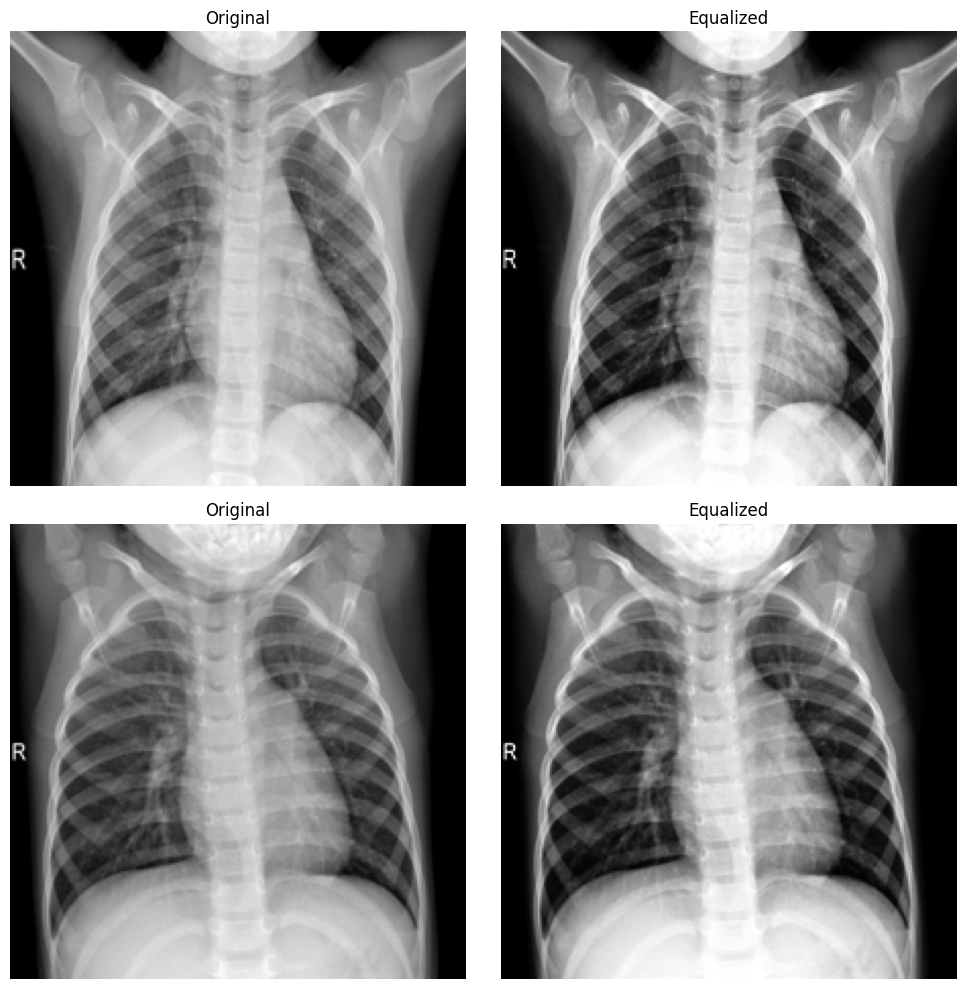

In [ ]:
from skimage import exposure

def show_images_with_equalization(base_directory, dataset_type, class_type, num_images, image_size=(224, 224)):
    """
    Display an arbitrary number of images from the specified class type ('NORMAL' or 'PNEUMONIA')
    with their original and histogram-equalized versions. Handles both RGB and grayscale images.

    Args:
        base_directory (str): Path to the base directory containing dataset subfolders.
        dataset_type (str): The dataset type ('train', 'val', or 'test').
        class_type (str): Class type to display ('NORMAL' or 'PNEUMONIA').
        num_images (int): Number of images to display.
        image_size (tuple): Tuple specifying the target size of the images (width, height).
    """
    # Step 1: Load image paths
    image_paths = load_images(base_directory, dataset_type, subfolder=class_type)

    if not image_paths:
        print(f"No images found in {dataset_type}/{class_type}.")
        return

    # Step 2: Randomly select the required number of images
    num_images = min(num_images, len(image_paths))  # Avoid selecting more images than available
    selected_paths = random.sample(image_paths, num_images)

    # Step 3: Load, resize, and apply histogram equalization to the selected images
    images = []
    for path in selected_paths:
        try:
            with Image.open(path) as img:
                img_resized = np.array(img.resize(image_size))

                if img_resized.ndim == 3:  # Colored (RGB)
                    # Apply histogram equalization to each channel
                    img_equalized = np.stack([
                        exposure.equalize_hist(img_resized[:, :, i]) for i in range(3)
                    ], axis=-1)
                else:  # Grayscale
                    img_equalized = exposure.equalize_hist(img_resized)

                images.append((img_resized, img_equalized, img_resized.ndim))
        except Exception as e:
            print(f"Error processing image {path}: {e}")

    # Step 4: Display the images in a grid
    num_cols = 2  # Original and Equalized side by side
    num_rows = num_images  # Each row represents one image pair
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))

    if num_rows == 1:  # Handle the case with only one image
        axes = [axes]

    for i, (original, equalized, ndim) in enumerate(images):
        # Original image
        ax = axes[i][0] if num_rows > 1 else axes[0]
        if ndim == 3:  # Colored image
            ax.imshow(original)
        else:  # Grayscale image
            ax.imshow(original, cmap='gray')
        ax.axis('off')
        ax.set_title("Original")

        # Equalized image
        ax = axes[i][1] if num_rows > 1 else axes[1]
        if ndim == 3:  # Colored image
            ax.imshow(equalized)
        else:  # Grayscale image
            ax.imshow(equalized, cmap='gray')
        ax.axis('off')
        ax.set_title("Equalized")

    plt.tight_layout()
    plt.show()

# Display 6 NORMAL images from the 'train' dataset with histogram equalization
show_images_with_equalization(main_dir, dataset_type="train", class_type="NORMAL", num_images=2)

#### 1. 2.6 Use ImageDataGenerator to augment image data by applying random transformations. This is often used in deep learning pipelines to artificially expand the size of the training dataset and improve the model's generalization.

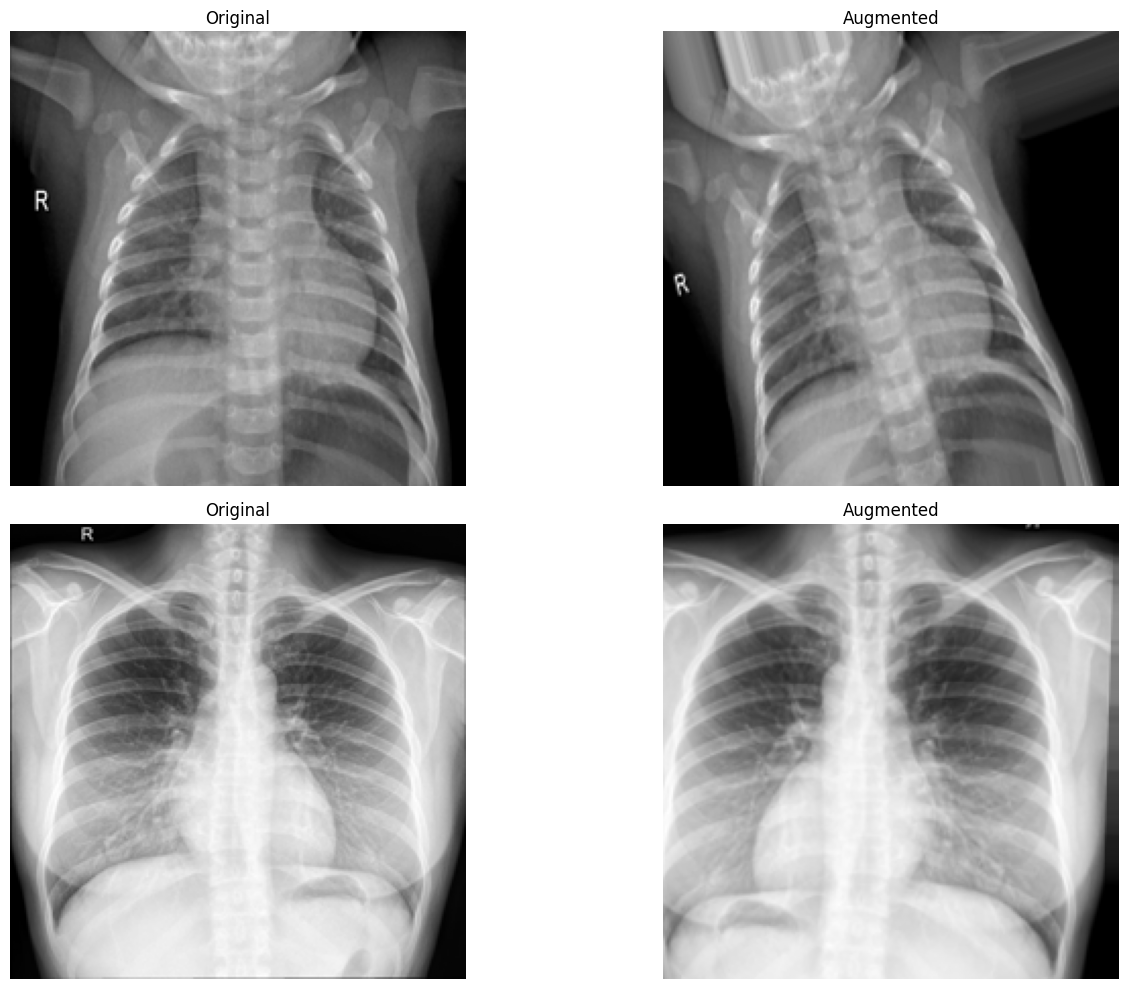

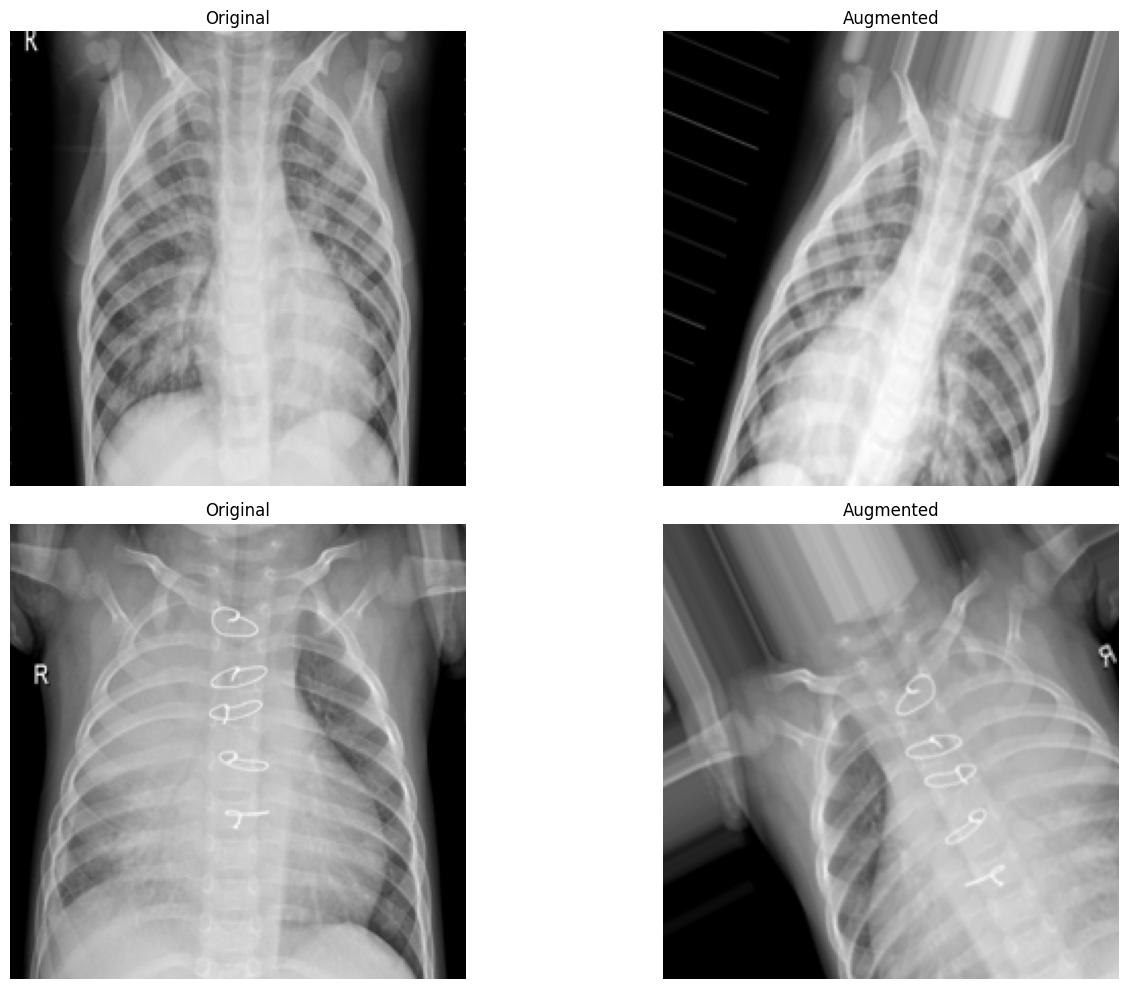

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def augment_data(base_directory, dataset_type, class_type, batch_size=16, image_size=(224, 224), num_images=5):
    """
    Augment images from the dataset using ImageDataGenerator and display the original
    and augmented versions side by side.

    Args:
        base_directory (str): Path to the base directory containing dataset subfolders.
        dataset_type (str): The dataset type ('train', 'val', or 'test').
        class_type (str): Class type to augment ('NORMAL' or 'PNEUMONIA').
        batch_size (int): Number of images per batch for augmentation.
        image_size (tuple): Target size of the images (width, height).
        num_images (int): Number of image pairs (original and augmented) to display.
    """
    # Define the data augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=30,  # Rotate images by up to 30 degrees
        width_shift_range=0.2,  # Shift the width by up to 20% of the image
        height_shift_range=0.2,  # Shift the height by up to 20% of the image
        shear_range=0.2,  # Apply shear transformations
        zoom_range=0.2,  # Zoom in or out by up to 20%
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode='nearest'  # Fill in any empty areas after transformations
    )

    # Load the image paths
    image_paths = load_images(base_directory, dataset_type, subfolder=class_type)

    if not image_paths:
        print(f"No images found in {dataset_type}/{class_type}.")
        return

    # Randomly select images
    selected_images = random.sample(image_paths, num_images)

    # Prepare the plot
    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5 * num_images))

    if num_images == 1:  # Handle single row case
        axes = [axes]

    for i, path in enumerate(selected_images):
        with Image.open(path) as img:
            # Resize the image to the target size
            img_resized = img.resize(image_size)
            img_array = np.array(img_resized)

            # Ensure the array has the correct shape
            if img_array.ndim == 2:  # Grayscale image
                img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Apply augmentation and get one transformed image
            augmented_images = datagen.flow(img_array, batch_size=1)
            augmented_image = augmented_images[0][0].astype('uint8')

            # Display the original image
            ax_original = axes[i][0]
            ax_original.imshow(img_resized, cmap='gray' if img_resized.mode == 'L' else None)
            ax_original.axis('off')
            ax_original.set_title("Original")

            # Display the augmented image
            ax_augmented = axes[i][1]
            ax_augmented.imshow(augmented_image.squeeze(), cmap='gray' if augmented_image.shape[-1] == 1 else None)
            ax_augmented.axis('off')
            ax_augmented.set_title("Augmented")

    plt.tight_layout()
    plt.show()

# Augment and display 5 images from the 'train' dataset, class 'NORMAL'
augment_data(
    base_directory=main_dir,
    dataset_type="train",
    class_type="NORMAL",
    num_images=2
)

# Augment and display 3 images from the 'train' dataset, class 'PNEUMONIA'
augment_data(
    base_directory=main_dir,
    dataset_type="train",
    class_type="PNEUMONIA",
    num_images=2
)


### 2. 1. Build a Vanilla CNN Model


First step, arrange the data in different constructs (x_train, y_train, x_test, y_test, x_val,y_val), etc...):



In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_data(directory, target_size=(150, 150)):
    """
    Load images from a directory into numpy arrays.

    Parameters:
    directory (str): Directory containing images.
    target_size (tuple): Tuple specifying the image size.

    Returns:
    list: List of image arrays.
    """
    images = []
    labels = []
    for label, subfolder in enumerate(['NORMAL', 'PNEUMONIA']):
        folder_path = os.path.join(directory, subfolder)
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            try:
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# One-hot
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")


Training data shape: (4172, 150, 150, 3), Labels shape: (4172, 2)
Validation data shape: (1044, 150, 150, 3), Labels shape: (1044, 2)
Testing data shape: (624, 150, 150, 3), Labels shape: (624, 2)


#### 2. 1.1. CNN Model
defines a CNN model with more than 18 layer.

1. Notice the **BatchNormalization** layer that is added to the model. This is often used to speed up the training process and make it more stable. It does so by normalizing the inputs from hidden layers.

2. The **Droput** layer: is used to prevent overfitting of the model. It does this by setting some input units to 0 during the training process (e.g. switching off some neurons in the network).



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    BatchNormalization,
    Dropout,
    Input,
)

def create_cnn_model(input_shape=(224, 224, 3), num_classes=2):
    """
    Create a CNN model with more than 18 layers, including BatchNormalization and Dropout.

    Args:
        input_shape (tuple): Shape of the input images (height, width, channels).
        num_classes (int): Number of output classes for classification.

    Returns:
        model: Compiled CNN model.
    """
    model = Sequential()

    # Input Layer
    model.add(Input(shape=input_shape))

    # Convolutional Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Convolutional Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Convolutional Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Convolutional Block 4
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#### 2. 1.2. Running The Model

Beafore runing the model use must fix the Imbalance Problem. please write a good solution and apply it to the Data.



In [ ]:
def analyze_class_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"Class {label}: {count} samples")

print("Training Data Distribution:")
analyze_class_distribution(np.argmax(y_train, axis=1))
print("Validation Data Distribution:")
analyze_class_distribution(np.argmax(y_val, axis=1))

Training Data Distribution:
Class 0: 1054 samples
Class 1: 3118 samples
Validation Data Distribution:
Class 0: 287 samples
Class 1: 757 samples


In [ ]:
import tensorflow as tf

# Oversample the minority class
def oversample_data(X, y):
    # Separate the data by class
    normal_idx = np.where(np.argmax(y, axis=1) == 0)[0]
    pneumonia_idx = np.where(np.argmax(y, axis=1) == 1)[0]

    # Oversample the minority class (PNEUMONIA)
    if len(normal_idx) > len(pneumonia_idx):
        minority_idx = pneumonia_idx
        majority_idx = normal_idx
    else:
        minority_idx = normal_idx
        majority_idx = pneumonia_idx

    # Randomly sample with replacement to match the majority class count
    minority_oversampled_idx = np.random.choice(
        minority_idx, size=len(majority_idx), replace=True
    )

    # Combine majority and oversampled minority indices
    balanced_indices = np.concatenate([majority_idx, minority_oversampled_idx])

    # Shuffle the balanced dataset
    np.random.shuffle(balanced_indices)

    # Create balanced datasets
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]

    return X_balanced, y_balanced

# Apply oversampling
X_train_balanced, y_train_balanced = oversample_data(X_train, y_train)
print("Balanced Training Data Distribution:")
analyze_class_distribution(np.argmax(y_train_balanced, axis=1))

Balanced Training Data Distribution:
Class 0: 3118 samples
Class 1: 3118 samples


Train the Model on the train data.



In [ ]:
model = create_cnn_model(input_shape=(150, 150, 3), num_classes=2)

# Train the model with the resized data
history = model.fit(
    X_train_balanced,
    y_train_balanced,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=8,
    verbose=1
)


Epoch 1/8
195/195 [==============================] - 638s 3s/step - loss: 0.2079 - accuracy: 0.9256 - val_loss: 2.4928 - val_accuracy: 0.7251
Epoch 2/8
195/195 [==============================] - 642s 3s/step - loss: 0.1053 - accuracy: 0.9663 - val_loss: 3.8175 - val_accuracy: 0.7251
Epoch 3/8
195/195 [==============================] - 636s 3s/step - loss: 0.0761 - accuracy: 0.9721 - val_loss: 0.6659 - val_accuracy: 0.8266
Epoch 4/8
195/195 [==============================] - 23236s 120s/step - loss: 0.0640 - accuracy: 0.9777 - val_loss: 0.0731 - val_accuracy: 0.9751
Epoch 5/8
195/195 [==============================] - 625s 3s/step - loss: 0.0563 - accuracy: 0.9809 - val_loss: 0.1452 - val_accuracy: 0.9454
Epoch 6/8
195/195 [==============================] - 634s 3s/step - loss: 0.0546 - accuracy: 0.9812 - val_loss: 0.3623 - val_accuracy: 0.8889
Epoch 7/8
195/195 [==============================] - 658s 3s/step - loss: 0.0518 - accuracy: 0.9822 - val_loss: 0.1278 - val_accuracy: 0.9531
Ep

show and plot the loss curve for training and validation.



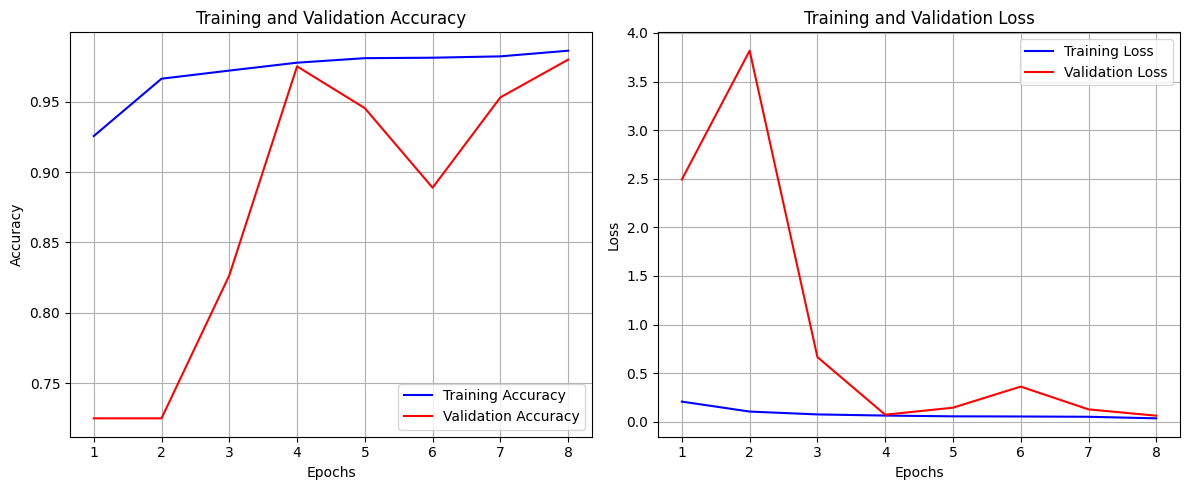

In [ ]:
def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss.

    Args:
        history: Training history object returned by model.fit().
    """
    # Extract values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training_history(history)


evaluate the model on test data.



In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

20/20 [==============================] - 11s 547ms/step - loss: 1.2802 - accuracy: 0.7484
Test Loss: 1.2802
Test Accuracy: 0.7484


### 3.1. Transfer Learning


#### 3.1.1. Pre-trained models

Here, we will use a pre-trained model to perform classification (Transfer Learning). Various models such as VGG16, XCeption,ResNet152V2, etc... can be used.Use one of this models.

Also notice that these models have been trained using large number of images.



##### Load Pre-trained Model

In [ ]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained ResNet152V2 model without the top layers
base_model = ResNet152V2(weights='C:/Users/HAMAHANG/Desktop/sut/S7/FDS/HW/4/resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

##### Add Custom Classification Head

In [ ]:
# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(2, activation='softmax')(x)  # Output layer for binary classification

# Define the final model
model = Model(inputs=base_model.input, outputs=output)

##### Compile the Model

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

##### Train the Model

In [ ]:
# Train the model on the balanced training data
history = model.fit(
    X_train_balanced,
    y_train_balanced,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=8,  # Start with fewer epochs for initial training
    verbose=1
)

Epoch 1/8
195/195 [==============================] - 651s 3s/step - loss: 0.2585 - accuracy: 0.9139 - val_loss: 0.1392 - val_accuracy: 0.9444
Epoch 2/8
195/195 [==============================] - 656s 3s/step - loss: 0.1410 - accuracy: 0.9472 - val_loss: 0.1078 - val_accuracy: 0.9617
Epoch 3/8
195/195 [==============================] - 625s 3s/step - loss: 0.1052 - accuracy: 0.9604 - val_loss: 0.1178 - val_accuracy: 0.9540
Epoch 4/8
195/195 [==============================] - 622s 3s/step - loss: 0.0971 - accuracy: 0.9654 - val_loss: 0.1010 - val_accuracy: 0.9579
Epoch 5/8
195/195 [==============================] - 645s 3s/step - loss: 0.0867 - accuracy: 0.9684 - val_loss: 0.0902 - val_accuracy: 0.9636
Epoch 6/8
195/195 [==============================] - 643s 3s/step - loss: 0.0665 - accuracy: 0.9755 - val_loss: 0.0999 - val_accuracy: 0.9646
Epoch 7/8
195/195 [==============================] - 672s 3s/step - loss: 0.0556 - accuracy: 0.9777 - val_loss: 0.0963 - val_accuracy: 0.9626
Epoch 

#### 3.1.2. show the confusion matrix for test data.



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class predictions
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded labels to class indices (if necessary)
y_test_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

20/20 [==============================] - 65s 3s/step
Confusion Matrix:
[[154  80]
 [  9 381]]


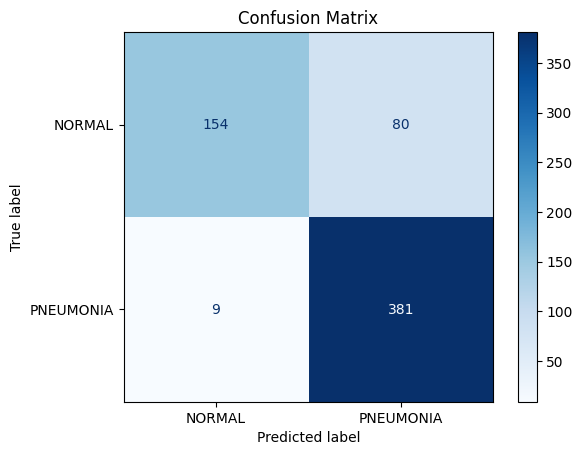

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### 4.1. Fine-tuning models
Notice that when we used pre-trained models, we haven't changed the weights, or retrained any of the Models layers. Simply put, we have updated the input and output of the models, while keeping all layers of the pre-trained models frozen. Although this is useful, in some cases we need to train some of the layers (update the weights of the model), and this is what is called fine-tuning the models. Here, we must going to unfreeze some layers and retrain. Note also, that we often keep lower layers frozen, because these capture generic features that may be shared with most images.




#### Fine_tune the Model

In [ ]:
# Unfreeze the top layers
for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']       

#### Train the Fine-tuned Model

In [ ]:
history_fine_tune = model.fit(
    X_train_balanced,
    y_train_balanced,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=8,
    verbose=1
)

Epoch 1/8
195/195 [==============================] - 769s 4s/step - loss: 0.0704 - accuracy: 0.9759 - val_loss: 0.1285 - val_accuracy: 0.9579
Epoch 2/8
195/195 [==============================] - 726s 4s/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 0.1395 - val_accuracy: 0.9579
Epoch 3/8
195/195 [==============================] - 734s 4s/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.0889 - val_accuracy: 0.9770
Epoch 4/8
195/195 [==============================] - 758s 4s/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.1164 - val_accuracy: 0.9703
Epoch 5/8
195/195 [==============================] - 755s 4s/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.1026 - val_accuracy: 0.9751
Epoch 6/8
195/195 [==============================] - 722s 4s/step - loss: 0.0103 - accuracy: 0.9973 - val_loss: 0.1274 - val_accuracy: 0.9703
Epoch 7/8
195/195 [==============================] - 749s 4s/step - loss: 0.0100 - accuracy: 0.9974 - val_loss: 0.2167 - val_accuracy: 0.9435
Epoch 

Evaluate the model on test data.



In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

20/20 [==============================] - 61s 3s/step - loss: 1.2915 - accuracy: 0.8013
Test Loss: 1.2915
Test Accuracy: 0.8013
